<a href="https://colab.research.google.com/github/anthonybabich/cap-comp215/blob/main/Copy_of_lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Anthony Babich
#### Date: 2/27/2023

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [ ]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [ ]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2D_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

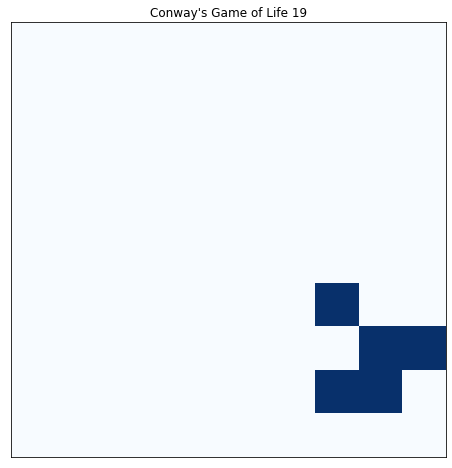

In [ ]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
 * how many unique states are there for a 3x3 (9 cell) neighbourhood?
 * how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
 * how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)
 * would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
 * propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
 * how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

In [ ]:
# Solutions for Ex. 1
 
 #Question 1: For a 9 cell neighbourhood there are two unique states, 0 or 1 and for the game of life alive or dead. The total number of possible configurations of the neighborhood is 2^9 which is 512.

#Question 2: There are 2^512(1.34078079E154) unique rules. 

#Question 3: There are approximitely 10^80 observable atoms in the universe.  The number of observable atoms in the universe is significantly smaller than the possible amount of unique rules  

#Question 4: Yes it could be reasonable to do. However, to go over every possible rule would be unreasonble because the amount is so large.

**Question 5**

Suppose there are 5 rules 



*   Rule 0: All cells die.



*   Rule 1: All cells stay the same.
*   Rule 2: Birth rule - a dead cell with exactly 3 live neighbors becomes alive


*   
Rule 3: Survival and birth rule - a live cell with 2 or 3 live neighbors survives, and a dead cell with exactly 3 live neighbors becomes alive.
*   Rule 4: Survival rule - a live cell with 2 or 3 live neighbors survives.

Let a unique rule number represent each of these rules. Rule 0 can be represented as 000000000, Rule 1 as 000000001, Rule 2 as 000000010, Rule 3 as 000000011, and Rule 4 as 000000100. Using this scheme, we can refer to each rule by its unique rule number, just as Wolfram's rule numbers are used to refer to specific cellular automata rules.







In [ ]:
binary_states = [f"{i:09b}" for i in range(2 ** 9)]
rule_numbers = {state: i for i, state in enumerate(binary_states)}
print(f"Rule number for neighborhood state (0, 0, 0, 0, 0, 0, 0, 0, 0): {rule_numbers['000000000']}")


Rule number for neighborhood state (0, 0, 0, 0, 0, 0, 0, 0, 0): 0


**Question 6**

To determine which rules corresponds to Conways GOL first create a 3x3 matrix. Then assign a 1 or 0 where 1 represents an alive cell and 0 represents a dead cell. Then generate the next state based on the GoL rules. If the central cell is alive and has 2 or 3 live neighbors, it survives. If it is dead and has exactly 3 live neighbors, it becomes alive otherwise it dies or stays dead. Then convert the cells into their next state with a zero or one based of these.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in lab 5

In [ ]:
# Solution for Ex. 2

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
     self.state = np.random.choice([0, 1], size=self.state.shape, p=[1 - p, p])

    def load_pattern(self, x, y, pattern):
        arr = pattern_to_array(pattern)
        x_len, y_len = arr.shape
        self.state[x:x+x_len, y:y+y_len] = arr

      



def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    life_object = BetterLife2D(n_rows, n_cols)
    life_object.randomize_state(p)
    return life_object

  

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

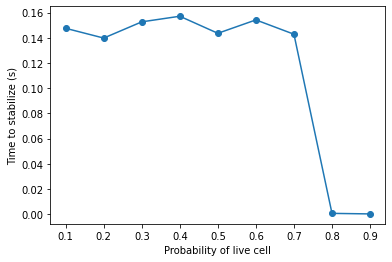

In [ ]:
def experiment(p_values, n_rows, n_cols=None, max_steps=1000):
    times = []
    for p in p_values:
        life = BetterLife2D(n_rows, n_cols)
        life.randomize_state(p)
        start_time = time.time()
        prev_state = np.copy(life.state)  
        for i in range(max_steps):
            life.step()
            if np.array_equal(life.state, prev_state):  
                times.append(time.time() - start_time)
                break
            prev_state = np.copy(life.state)
        else:
            times.append(time.time() - start_time)
    return times

p_values = np.linspace(0.1, 0.9, num=9)
n_rows = 50
n_cols = 50
max_steps = 1000

times = experiment(p_values, n_rows, n_cols, max_steps)

plt.plot(p_values, times, 'o-')
plt.xlabel('Probability of live cell')
plt.ylabel('Time to stabilize (s)')
plt.show()

It looks like from probabilities 0.1-0.7 it takes between 0.14-0.16 seconds to stabilize and from 0.8-0.9 probability it takes 0.00 seconds to stabilize. A conclusion could be that for lower probabilities it takes longer to stabilize.

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add an `load_pattern(x, y, pattern)` method to your BetterLife2D class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [ ]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Solution for Ex. 3
def pattern_to_array(pattern):
    lines = pattern.strip().split('\n')
    lst = [[int(c) for c in line.strip()] for line in lines]
    arr = np.array(lst)
    return arr


glider_array = pattern_to_array("""
    010
    001
    111
    """)

print(glider_array)

[[0 1 0]
 [0 0 1]
 [1 1 1]]


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [ ]:
# define your patterns here
 
blinker = """
010
010
010
"""

toad = """
0000
0110
0110
0000
"""

beacon = """
1100
1100
0011
0011
"""

glider = """
010
001
111
"""

print(pattern_to_array(blinker))

print(pattern_to_array(toad))

print(pattern_to_array(beacon))

print(pattern_to_array(glider))

[[0 1 0]
 [0 1 0]
 [0 1 0]]
[[0 0 0 0]
 [0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]]
[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]
[[0 1 0]
 [0 0 1]
 [1 1 1]]


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

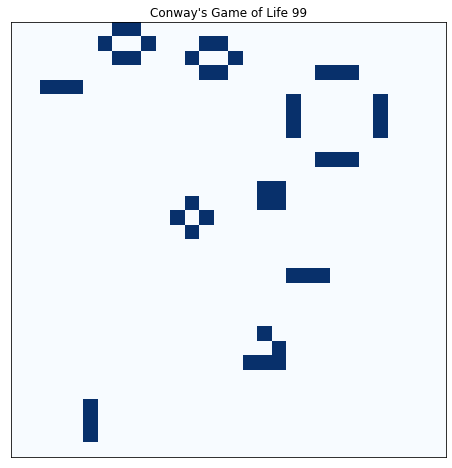

In [ ]:
# code for your experiment here

pulsar = """
0000000000000
0000000000000
0000000111000
0000000000100
0010000000100
0010000111000
0000000100000
0000000111000
0000000000100
0000000111000
0000000000000
0000000000000
"""

beehive = """
00000
00100
01010
00100
00000
"""

loaf = """
00000
00100
01010
00100
00010
00001
"""

life = BetterLife2D(30, 30)

life.load_pattern(1, 1, pulsar)
life.load_pattern(6, 6, beehive)
life.load_pattern(14, 14, loaf)

animation_object = Animation2D(life, frames=100)
animation_object.animate(interval=0.2)



From studying these interactions we can learn how all sorts of behavious can arise from simple rules. It has real world applications to a wide range of things such as biology and physics models.